# Chapter 3: models

## Setup

In [1]:
using Ogre
import Onion
using WaterData
using DataFrames
using DataFramesMeta
using Plots
using StatPlots
using ThesisUtils
using LaTeXStrings
using ProgressMeter
using DataStructures: OrderedDict

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #readtable#232(::Bool, ::Char, ::Array{Char,1}, ::Char, ::Array{String,1}, ::Array{String,1}, ::Array{String,1}, ::Bool, ::Int64, ::Array{Symbol,1}, ::Array{Any,1}, ::Bool, ::Char, ::Bool, ::Int64, ::Array{Int64,1}, ::Bool, ::Symbol, ::Bool, ::Bool, ::DataFrames.#readtable, ::String) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:1045
 [3] (::DataFrames.#kw##readtable)(::Array{Any,1}, ::DataFrames.#readtable, ::String) at ./<missing>:0
 [4] include_from_node1(::String) at ./loading.jl:576
 [5] include(::String) at ./sysimg.jl:14
 [6] include_from_node1(::String) at ./loading.jl:576
 [7] eval(::Module, ::Any) at ./boot.jl:235
 [8] _require(::Symbol) at ./loading.jl:490
 [9] require(::Symbol) at ./loading.jl:405
 [10] include_string(::String, ::String) at ./loading.jl:522
 [11] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/sthomas/.julia/v0.6/IJulia/src/execute_request.jl:180
 [12] (::Compat.#inner#

## Seager et al 2007

We check whether we can reproduce the mass-radius diagrams by Seager et al (2007) using their EOS - if so, this is an indication that our integrator is working correctly.

### EOS

In [2]:
# the WaterData package contains the EOSes used by Seager et al (2007)
eoses = WaterData.load_piecewise_eoses()

Dict{String,Any} with 5 entries:
  "mgsio3"      => WaterData.LineEOS([100000.0, 1.9307e5, 3.72759e5, 7.19686e5,…
  "iceX"        => WaterData.BoundedEOS{WaterData.LineEOS}(WaterData.LineEOS([1…
  "h2o"         => WaterData.LineEOS([100000.0, 1.9307e5, 3.72759e5, 7.19686e5,…
  "fe"          => WaterData.LineEOS([100000.0, 1.9307e5, 3.72759e5, 7.19686e5,…
  "iceX_beyond" => WaterData.BoundedEOS{WaterData.LineEOS}(WaterData.LineEOS([1…

In [3]:
# Fe, ϵ phase, Vinet at low pressures then TFD at high temperatures
fe = eoses["fe"]
# MgSiO3 perovskite, 4th order BME at low pressures then ditto
mgsio3 = eoses["mgsio3"]
# H2O, ice VII, 3rd order BME then density function theory
# calculations then TFD at high pressures
h2o = eoses["h2o"];

### Plot

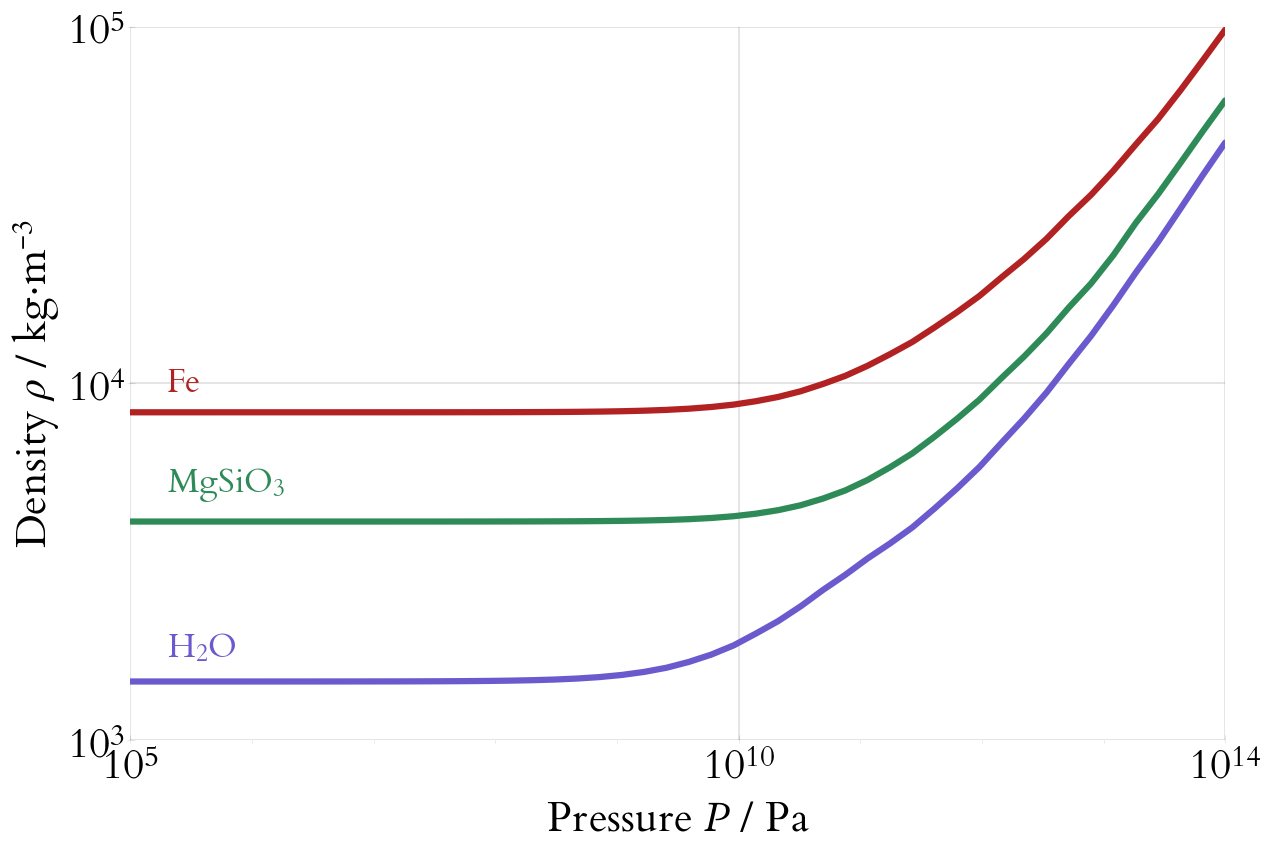

In [4]:
autofig("simple-eos-comparison", Normal) do
    P = logspace(5, 14)
    
    ρ_h2o = map(h2o, P)
    ρ_mgsio3 = map(mgsio3, P)
    ρ_fe = map(fe, P)
    
    colors = [:slateblue :seagreen :firebrick]
    
    plot(P, [ρ_h2o ρ_mgsio3 ρ_fe], c=colors,
        framestyle = :grid,
        xaxis=((1e5, 1e14), :log10, L"Pressure $P$ / Pa"), 
        yticks=[1e3, 1e4, 1e5],
        xticks=[1e5, 1e10, 1e14],
        yaxis=((1e3, 1e5), :log10, L"Density $ρ$ / kg$⋅$m$^{-3}$"),
        legend=false)
    annotate_color!(2e5, 1.8e3, L"H$_2$O", colors[1], plotsize=Margin)
    annotate_color!(2e5, 5.2e3, L"MgSiO$_3$", colors[2], plotsize=Margin)
    annotate_color!(2e5, 1e4, "Fe", colors[3], plotsize=Margin)
end;

## Planet interiors

### Setup

In [5]:
# Compare to Seager's mass--radius diagrams

# the starting pressure is pretty arbitrary since the EOS is constant with
# pressure to ~ 1 GPa - Seager use a boundary condition of 0 so let's pick 
# a meagre 1 Pa
Psurf = 1    # Pa

Rguess = R_earth
Rbracket = [0, 3Rguess]
Npoints = 500

"Get the radius of an isothermal planet of mass M using a given EOS"
function R_isothermal(M, eos)
    boundary_vals = Ogre.ValueSet(M, Rguess, Psurf)
    grid = Ogre.mass_grid(M, 0.5, Npoints)
    planet = Ogre.PlanetSystem(M, eos, boundary_vals, grid, Rbracket)
    
    Ogre.find_radius!(planet)
end

"Read a table from figdata/"
function loaddata(f)
    open("figdata/$f") do file
        readtable(file, allowcomments=true)
    end
end

"Write a table to figdata/"
function savedata(f, df)
    writetable("figdata/$f.csv", df)
end;

### Plots

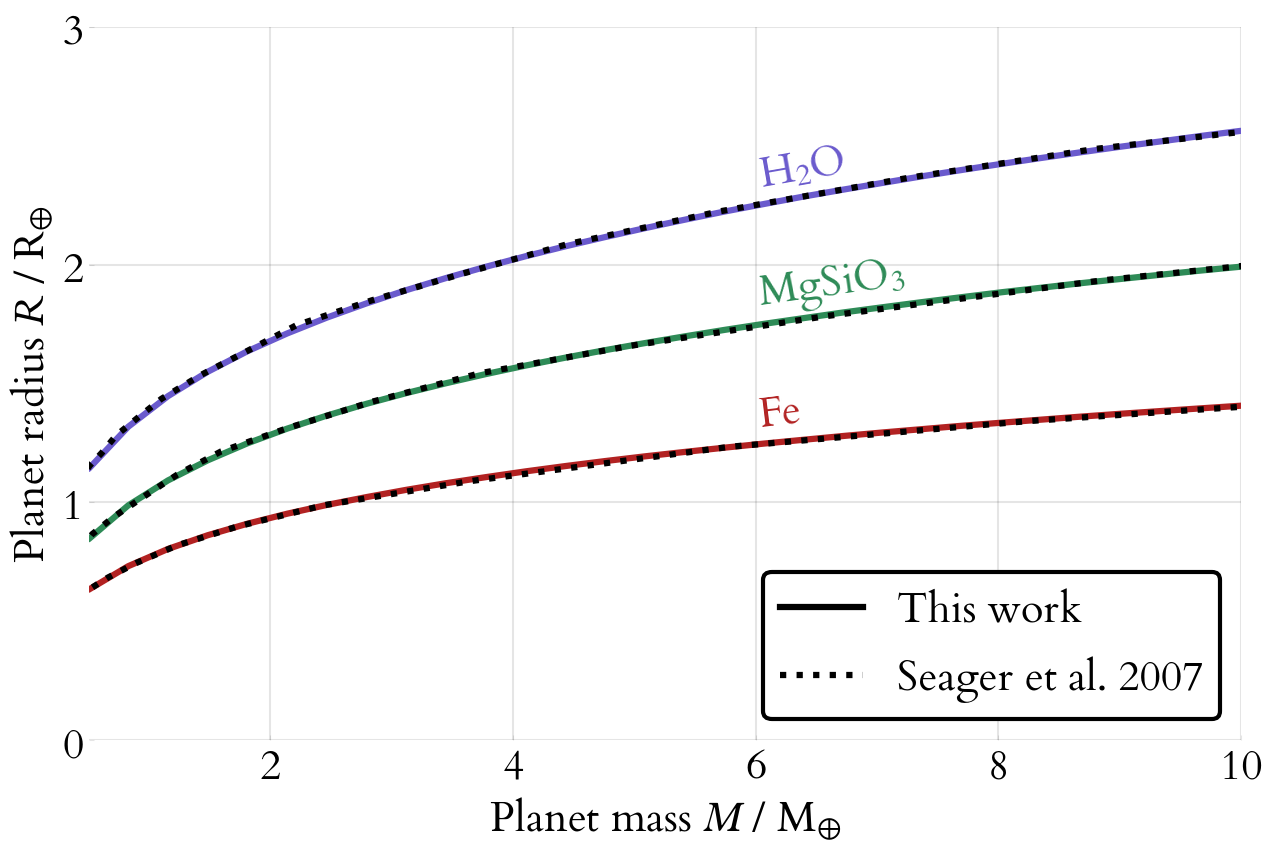

In [6]:
autofig("seager-mr-comparisons", Normal) do
    # plot our data
    masses = linspace(0.5M_earth, 10M_earth, 30)
    radii = map([h2o, mgsio3, fe]) do eos
        map(m -> R_isothermal(m, eos), masses)
    end
    colors = [:slateblue :seagreen :firebrick]
    plot(masses/M_earth, radii/R_earth, 
        label = "",
        legend = :bottomright,
        c = colors,
        framestyle = :grid,
        xaxis = ((0.5,10), L"Planet mass $M$ / M$_⊕$"),
        yaxis = ((0, 3), L"Planet radius $R$ / R$_⊕$"))
    plot!([-99], [-99], color=:black, label="This work")
    
    # plot seager's data
    s_h2o = loaddata("raw/massradius/seager2007/h2o.csv") |> sort
    s_mgsio3 = loaddata("raw/massradius/seager2007/mgsio3.csv") |> sort
    s_fe = loaddata("raw/massradius/seager2007/fe.csv") |> sort
    foreach((s_h2o, s_mgsio3, s_fe)) do d
        plot!(d[:mass], d[:radius], linecolor=:black, linestyle=:dot, label="")
    end
    plot!([-99], [-99], color=:black, linestyle=:dot, label="Seager et al. 2007")
    
    annotate_color!(6, 2.4, L"H$_2$O", colors[1], rotation=10)
    annotate_color!(6, 1.91, L"MgSiO$_3$", colors[2], rotation=8)
    annotate_color!(6, 1.37, "Fe", colors[3], rotation=7)
end;

## Valencia et al 2007

We compare our interior models to an Earth-like model as produced by Valencia et al in their 2007 paper "Detailed Models of Super-Earths [...]".

In Figure 3 of that paper, they have a mass-radius relationship for terrestrial planets with various water layers. We will make some simple models with isothermal cores/mantles and then water layers on top to see how this compares.
We expect the dry planet (no water layer) to be pretty similar, with maybe some small differences because we are using simple isothermal EOSes taken from Seager et al (2007) for the iron and MgSiO3 phases. As far as I can tell, Valencia's 2007 paper only uses the ice VII EOS for water, so we expect bigger differences when we stack the water layer on top, since I have a more complete EOS.

I wanted to compare to a similar model in Valencia et al 2013, "Bulk composition of GJ 1214b [...]", this time with a H2O envelope which used an atmospheric code. They find significantly inflated radii here, so it would be interesting to see how our results compare, especially since they switched to a more complete EOS treatment. But I couldn't directly make this comparison because of the atmospheric aspect to it - our model does interiors, so it doesn't handle anything less than about 1 bar, and they have a more complicated model which handles an atmosphere. [note: this was written before I added the atmospheric portion to my models] I wanted to show evidence of a large inflated radius due to temperature effects in the low-density water layer, but I chose to compare to a plot from Lopez et al to show this instead (below).

### Setup

In [7]:
# We'll use the simple EOSes from above + our full H2O EOS for the water layer
core_eos = fe
mantle_eos = mgsio3
full_h2o_eos = WaterData.load_full_eos()["grid"]

# Use the tabulated H2O heat capacity
cₚ = WaterData.load_heat_capacity()["heatcap_h2o"]

# Set up solver options
Rguess = R_earth
Rbracket = [0, 10R_earth]
Npoints = 500

"Get the radius of a multilayer iron/silicate/water layer planet"
function R_adiabat_cored(M, h2ofrac, Psurf, Tsurf)
    # do a simpler isothermal calculation if there's no water layer
    if h2ofrac == 0
        return R_isotherm_nowater(M, Psurf)
    end
    
    # mantle and core fractions, assuming mantle is 2x mass of core
    mantlecorefrac = 1 - h2ofrac
    corefrac = 1/3 * mantlecorefrac
    mantlefrac = 2 * corefrac
    massfracs = [corefrac, mantlefrac, h2ofrac]
    @assert sum(massfracs) ≈ 1
    
    # surface boundary conditions
    bvs = Ogre.ValueSet(M, Rguess, Psurf, Tsurf)
    grid = Ogre.mass_grid(M, mantlecorefrac, Npoints)
    
    # make the layer-piecewise EOS based on those mass fractions
    eoses = [core_eos, mantle_eos, full_h2o_eos]
    coredeos = Ogre.MassPiecewiseEOS(eoses, M, massfracs)
    
    # make and solve planet radius
    planet = Ogre.PlanetSystem(M, coredeos, cₚ, bvs, grid, Rbracket)
    Ogre.find_radius!(planet)
end

"Get the radius of an iron/silicate planet"
function R_isotherm_nowater(M, Psurf)
    # surface boundary conditions
    bvs = Ogre.ValueSet(M, Rguess, Psurf)
    grid = Ogre.mass_grid(M, 0.5, Npoints)
    
    # mantle and core fractions, assuming mantle is 2x mass of core
    massfracs = [1/3, 2/3]
    
    # make the layer-piecewise EOS based on those mass fractions
    eoses = [core_eos, mantle_eos]
    eos = Ogre.MassPiecewiseEOS(eoses, M, massfracs)
    
    # make and solve planet radius
    planet = Ogre.PlanetSystem(M, eos, bvs, grid, Rbracket)
    Ogre.find_radius!(planet)
end;

In [8]:
# Sanity check: do we get roughly R⊕ when we use a M⊕ sized planet as input?
# Do we find that the planet is bigger if we replace some of it with water?

# 0% water, 33% Fe, 66% MgSiO3
@show R_adiabat_cored(M_earth, 0, 1e10, 300) / R_earth 

# 50% water
@show R_adiabat_cored(M_earth, 0.5, 1e10, 300) / R_earth;

R_adiabat_cored(M_earth, 0, 1.0e10, 300) / R_earth = 0.9612984955310822
R_adiabat_cored(M_earth, 0.5, 1.0e10, 300) / R_earth = 1.170978993177414


looks good!

### Plots

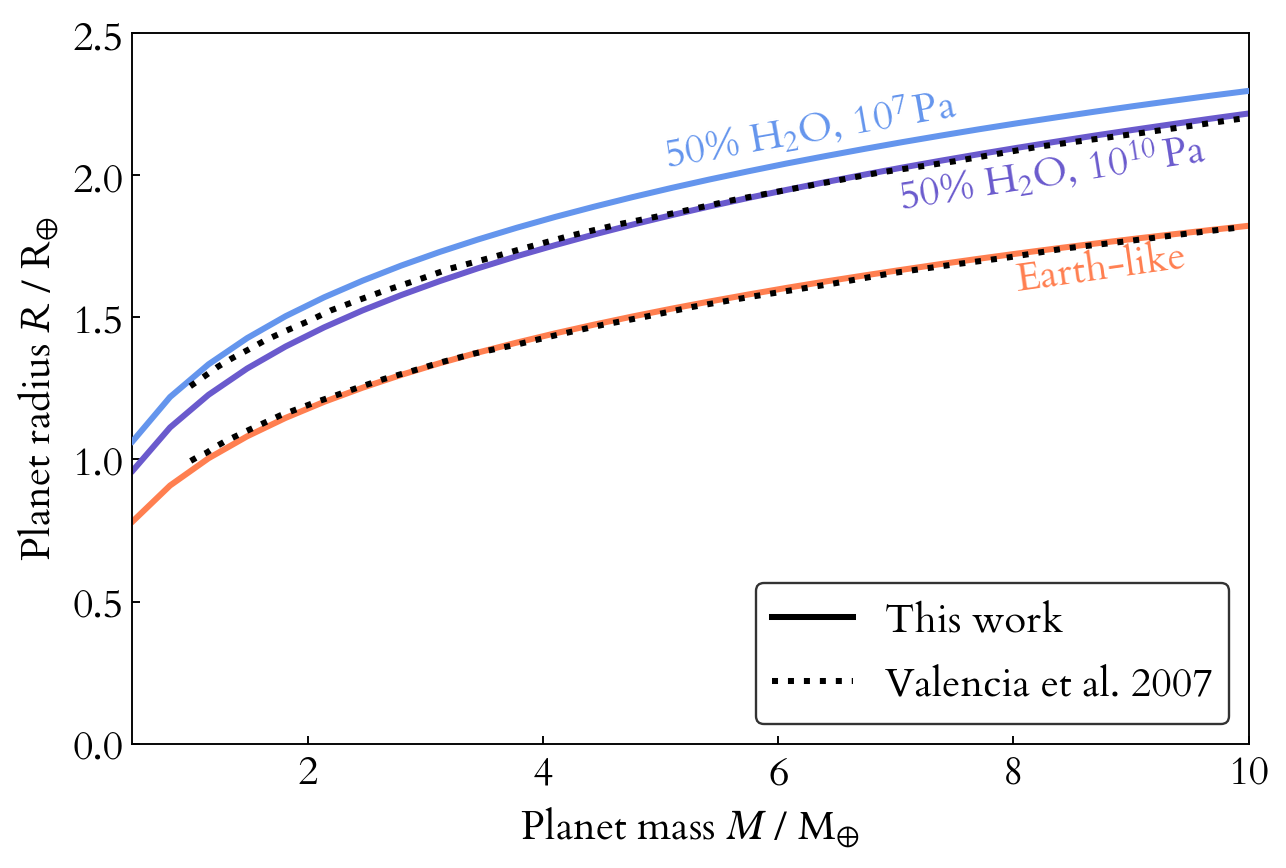

In [9]:
autofig("valencia-mr-comparison", Normal) do
    # make MR diagrams
    masses = linspace(0.5M_earth, 10M_earth, 30)
    radii_dry = map(masses) do M
        R_adiabat_cored(M, 0, 1e10, 550)
    end
    radii_wet_1e10Pa = map(masses) do M
        R_adiabat_cored(M, 0.5, 1e10, 550)
    end
    radii_wet_1e7Pa = map(masses) do M
        R_adiabat_cored(M, 0.5, 1e7, 550)
    end

    radii = [radii_dry radii_wet_1e10Pa radii_wet_1e7Pa]
    colors = [:coral :slateblue :cornflowerblue]

    p = plot(masses/M_earth, radii/R_earth,
        framestyle = :box,
        legend = :bottomright,
        c=colors,
        label="",
        xaxis=((0.5,10), L"Planet mass $M$ / M$_⊕$"),
        yaxis=((0, 2.5), L"Planet radius $R$ / R$_⊕$"))
    plot!([-99], [-99], color=:black, label="This work")
    annotate_color!(8, 1.67, "Earth-like", colors[1], rotation=8)
    annotate_color!(5, 2.15, L"50% H$_2$O, 10$^7\,$Pa", colors[3], rotation=10)
    annotate_color!(7, 2.0, L"50% H$_2$O, 10$^{10}\,$Pa", colors[2], rotation=9)

    # plot valencia's data
    v_dry = loaddata("raw/massradius/valencia2007/dry.csv") |> sort
    v_wet = loaddata("raw/massradius/valencia2007/wet.csv") |> sort
    foreach((v_dry, v_wet)) do d
        # her results are given in km
        plot!(d[:mass], d[:radius] * 1000 / R_earth, color=:black, linestyle=:dot, label="")
    end
    plot!([-99], [-99], linestyle=:dot, color=:black, label="Valencia et al. 2007")
end;

## Lopez et al 2012

This is the best paper I could find that shows the effect of an inflated water radius at high temperatures, so I thought it deserved a comparison. I could have sworn I saw another similar plot somewhere (by Nettelmann et al?) but I couldn't find it, so I'll compare to this paper instead.

### Plots

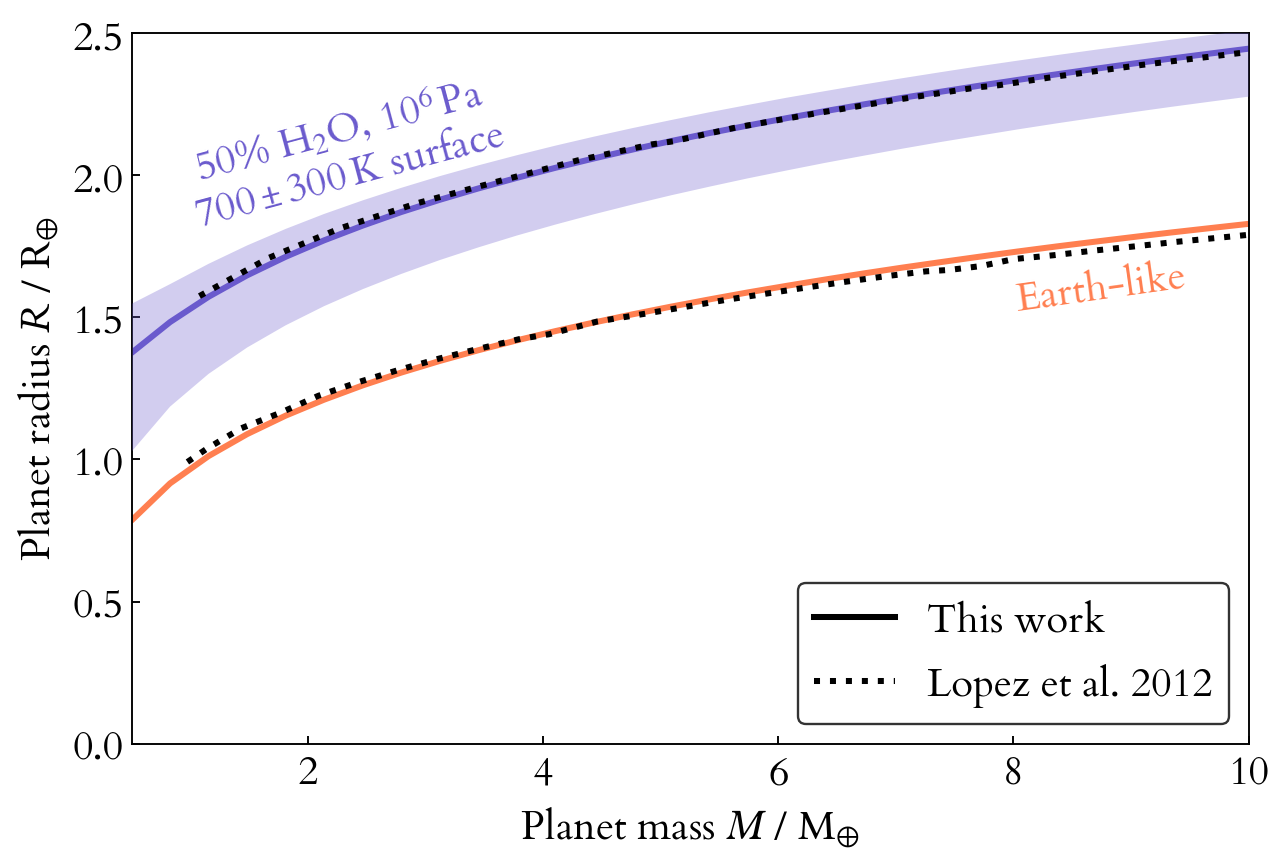

In [10]:
autofig("lopez-mr-comparisons", Normal) do
    # make MR diagrams
    masses = linspace(0.5M_earth, 10M_earth, 30)
    Psurf = 1e6
    Tsurf = 700
    ΔT = 300
    radii_dry = map(masses) do M
        R_adiabat_cored(M, 0, Psurf, Tsurf)
    end
    radii_wet50 = map(masses) do M
        R_adiabat_cored(M, 0.5, Psurf, Tsurf)
    end
    radii_wet50_hotter = map(masses) do M
        R_adiabat_cored(M, 0.5, Psurf, Tsurf + ΔT)
    end
    radii_wet50_cooler = map(masses) do M
        R_adiabat_cored(M, 0.5, Psurf, Tsurf - ΔT)
    end

    radii = [radii_dry radii_wet50]
    radii_band = [radii_wet50_hotter radii_wet50_cooler]

    colors = [:coral :slateblue]
    plot(masses/M_earth, radii/R_earth, 
        c=colors,
        framestyle = :box,
        legend = :bottomright,
        label="",
        xaxis=((0.5,10), L"Planet mass $M$ / M$_⊕$"),
        yaxis=((0, 2.5), L"Planet radius $R$ / R$_⊕$"))
    plot!(masses/M_earth, radii_wet50_hotter/R_earth, 
        linewidth=0,
        fillalpha=0.3,
        fillrange=radii_wet50_cooler/R_earth, 
        fillcolor=:slateblue,
        label="")
    plot!([-99], [-99], color=:black, label="This work")

    annotate_color!(8, 1.6, "Earth-like", colors[1], rotation=8)
    annotate_color!(1, 2.15, L"50% H$_2$O, 10$^{6}\,$Pa", colors[2], rotation=15)
    annotate_color!(1, 2.0, L"$700 \pm 300\,$K surface", colors[2], rotation=15)

    # plot lopez's data
    l_dry = loaddata("raw/massradius/lopez2012/dry.csv") |> sort
    l_wet50 = loaddata("raw/massradius/lopez2012/wet50.csv") |> sort
    foreach((l_dry, l_wet50)) do d
        plot!(d[:mass], d[:radius], label="", color=:black, linestyle=:dot)
    end
    plot!([-99], [-99], color=:black, linestyle=:dot, label="Lopez et al. 2012")
end;

## MR curve parameter search

### Functions for parameter search

In [35]:
Rbracket = [0, 10R_earth]
Ts = 300:100:1000
mgsio3_fe_ratio = 2
masses = linspace(0.5M_earth, 10M_earth, 30)

isotherms = OrderedDict{Int, WaterData.LineEOS}()
for T in Ts
    isotherms[T] = WaterData.slice(full_h2o_eos, T)
end

function R_adiabat_watersphere(M, Psurf, Tsurf)
    bvs = Ogre.ValueSet(M, R_earth, Psurf, Tsurf)
    grid = Ogre.mass_grid(M, 0.5, Npoints)
    planet = Ogre.PlanetSystem(M, full_h2o_eos, cₚ, bvs, grid, Rbracket)
    
    Ogre.find_radius!(planet)
end

function R_isotherm_earthsphere(M, Psurf)
    bvs = Ogre.ValueSet(M, R_earth, Psurf)
    grid = Ogre.mass_grid(M, 0.5, Npoints)
    fefrac = 1/(mgsio3_fe_ratio + 1)
    mgsio3frac = fefrac * mgsio3_fe_ratio
    massfracs = [fefrac, mgsio3frac]
    @assert sum(massfracs) ≈ 1
    eos = Ogre.MassPiecewiseEOS([fe, mgsio3], M, massfracs)
    planet = Ogre.PlanetSystem(M, eos, bvs, grid, Rbracket)
    
    Ogre.find_radius!(planet)
end

function R_isotherm(M, Psurf, Tsurf, h2ofrac)
    if h2ofrac == 0
        return R_isotherm_earthsphere(M, Psurf)
    end
    
    bvs = Ogre.ValueSet(M, R_earth, Psurf, Tsurf)
    corefrac = 1 - h2ofrac
    grid = Ogre.mass_grid(M, corefrac, Npoints)
    fefrac = corefrac/(mgsio3_fe_ratio + 1)
    mgsio3frac = fefrac * mgsio3_fe_ratio
    massfracs = [fefrac, mgsio3frac, h2ofrac]
    @assert sum(massfracs) ≈ 1
    h2oslice = WaterData.slice(full_h2o_eos, Tsurf)
    eos = Ogre.MassPiecewiseEOS([fe, mgsio3, h2oslice], M, massfracs)
    planet = Ogre.PlanetSystem(M, eos, cₚ, bvs, grid, Rbracket)
    
    Ogre.find_radius!(planet)
end

function R_adiabat(M, Psurf, Tsurf, h2ofrac)
    @assert 0 <= h2ofrac <= 1
    if h2ofrac == 0
        return R_isotherm_earthsphere(M, Psurf)
    end
    if h2ofrac == 1
        return R_adiabat_watersphere(M, Psurf, Tsurf)
    end

    bvs = Ogre.ValueSet(M, R_earth, Psurf, Tsurf)
    corefrac = 1 - h2ofrac
    grid = Ogre.mass_grid(M, corefrac, Npoints)
    fefrac = corefrac/(mgsio3_fe_ratio + 1)
    mgsio3frac = fefrac * mgsio3_fe_ratio
    massfracs = [fefrac, mgsio3frac, h2ofrac]
    @assert sum(massfracs) ≈ 1
    eos = Ogre.MassPiecewiseEOS([fe, mgsio3, full_h2o_eos], M, massfracs)
    planet = Ogre.PlanetSystem(M, eos, cₚ, bvs, grid, Rbracket)
    
    Ogre.find_radius!(planet)
end

function R_adiabat_onion(M, P_surf, T_surf, h2ofrac)
    @assert 0 <= h2ofrac <= 1
    if h2ofrac == 0
        planet = Onion.DryPlanet(M = M, P_surf = P_surf, T_surf = T_surf, f_core = 1//3)
    elseif h2ofrac == 1
        planet = Onion.WaterPlanet(M = M, P_surf = P_surf, T_surf = T_surf)
    else
        f_nucleus = 1 - h2ofrac
        f_core = 1//3 * f_nucleus
        f_mantle = 2//3 * f_nucleus
        planet = Onion.ThreeLayerPlanet(M = M, P_surf = P_surf, T_surf = T_surf, 
            isothermal = false, f_core = f_core, f_mantle = f_mantle)
    end
     
    Onion.solve_radius(planet)
end;     

In [12]:
# Sanity checks: do we produce smaller planets when we don't have a water layer?
@show R_adiabat(M_earth, 1e5, 300, 0) / R_earth   # 0% water
@show R_adiabat(M_earth, 1e5, 300, 0.5) / R_earth # 50% water
@show R_adiabat(M_earth, 1e5, 300, 1) / R_earth;   # 100% water;

R_adiabat(M_earth, 100000.0, 300, 0) / R_earth = 0.9689182043075562
R_adiabat(M_earth, 100000.0, 300, 0.5) / R_earth = 1.2242234498262405
R_adiabat(M_earth, 100000.0, 300, 1) / R_earth = 1.4017851650714874


### Data generation

#### OGRE

In [23]:
# Let's generate the data!
# We save this separately because it takes a while, so we can 
# skip these cells if we don't need to rerun the whole analysis

# First: isotherms vs adiabats - OGRE only
Psurf = 1e7
h2ofrac = 0.3
p = Progress(length(Ts) * 2 * length(masses))
for method in (R_isotherm, R_adiabat)
    d = DataFrame(mass=masses)
    for Tsurf in Ts
        rs = map(d[:mass]) do M
            next!(p)
            method(M, Psurf, Tsurf, h2ofrac)
        end
        d[Symbol(Tsurf)] = rs
    end
    savedata("generated/massradius/isotherms_vs_adiabats/ogre/$method.jl", d)
end

Progress:  50%|████████████████████                     |  ETA: 0:00:30WARNING: writetable is deprecated, use CSV.write from the CSV package instead
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #writetable#185(::Bool, ::Char, ::Char, ::String, ::Bool, ::Function, ::String, ::DataFrames.DataFrame) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:69
 [3] writetable(::String, ::DataFrames.DataFrame) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:69
 [4] macro expansion at ./In[23]:18 [inlined]
 [5] anonymous at ./<missing>:?
 [6] include_string(::String, ::String) at ./loading.jl:515
 [7] include_string(::Module, ::String, ::String) at /home/sthomas/.julia/v0.6/Compat/src/Compat.jl:174
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/sthomas/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] (::Compat.#inner#16{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/sthomas/.julia/v0.6/Compat/src/Compat.jl:496


In [40]:
# Second: varying water fractions - OGRE
h2ofracs = [0, 1, 5, 10, 30, 50] ./ 100
p = Progress(length(Ts) * length(h2ofracs) * length(masses))
for h2ofrac in h2ofracs
    d = DataFrame(mass=masses)
    for Tsurf in Ts
        rs = map(d[:mass]) do M
            next!(p)
            R_adiabat(M, Psurf, Tsurf, h2ofrac)
        end        
        d[Symbol(Tsurf)] = rs
    end
    h2opc = trunc(Int, h2ofrac * 100)
    savedata("generated/massradius/h2ofractions/ogre/$(h2opc)pc", d)
end

Progress:  17%|███████                                  |  ETA: 0:01:29WARNING: writetable is deprecated, use CSV.write from the CSV package instead
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #writetable#185(::Bool, ::Char, ::Char, ::String, ::Bool, ::Function, ::String, ::DataFrames.DataFrame) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:69
 [3] writetable(::String, ::DataFrames.DataFrame) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:69
 [4] macro expansion at ./In[40]:14 [inlined]
 [5] anonymous at ./<missing>:?
 [6] include_string(::String, ::String) at ./loading.jl:515
 [7] include_string(::Module, ::String, ::String) at /home/sthomas/.julia/v0.6/Compat/src/Compat.jl:174
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/sthomas/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] (::Compat.#inner#16{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/sthomas/.julia/v0.6/Compat/src/Compat.jl:496


In [33]:
# varying water fractions - ONION
h2ofracs = [0, 1, 5, 10, 30, 50] ./ 100
p = Progress(length(Ts) * length(h2ofracs) * length(masses))
for h2ofrac in h2ofracs
    d = DataFrame(mass=masses)
    for Tsurf in Ts
        rs = map(d[:mass]) do M
            next!(p)
            R_adiabat_onion(M, Psurf, Tsurf, h2ofrac)
        end        
        d[Symbol(Tsurf)] = rs
    end
    h2opc = trunc(Int, h2ofrac * 100)
    savedata("generated/massradius/h2ofractions/onion/$(h2opc)pc", d)
end

In [20]:
# Third: varying surface pressures, 30% water fraction - OGRE
Psurfs = [10^x for x=5:10]
h2ofrac = 0.3
p = Progress(length(Ts) * length(Psurfs) * length(masses))
for Psurf in Psurfs
    d = DataFrame(mass = masses)
    for Tsurf in Ts
        rs = map(d[:mass]) do M
            next!(p)
            R_adiabat(M, Psurf, Tsurf, h2ofrac)
        end      
        d[Symbol(Tsurf)] = rs
    end
    P = round(Int, log10(Psurf))
    savedata("generated/massradius/surfacepressures/ogre/1e$P", d)
end

Progress:  17%|███████                                  |  ETA: 0:03:04WARNING: writetable is deprecated, use CSV.write from the CSV package instead
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #writetable#185(::Bool, ::Char, ::Char, ::String, ::Bool, ::Function, ::String, ::DataFrames.DataFrame) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:69
 [3] writetable(::String, ::DataFrames.DataFrame) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:69
 [4] macro expansion at ./In[20]:15 [inlined]
 [5] anonymous at ./<missing>:?
 [6] include_string(::String, ::String) at ./loading.jl:515
 [7] include_string(::Module, ::String, ::String) at /home/sthomas/.julia/v0.6/Compat/src/Compat.jl:174
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/sthomas/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] (::Compat.#inner#16{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/sthomas/.julia/v0.6/Compat/src/Compat.jl:496


In [42]:
# Third: varying surface pressures, 30% water fraction - ONION
Psurfs = [10^x for x=5:10]
h2ofrac = 0.3
p = Progress(length(Ts) * length(Psurfs) * length(masses))
for Psurf in Psurfs
    d = DataFrame(mass = masses)
    for Tsurf in Ts
        rs = map(d[:mass]) do M
            next!(p)
            R_adiabat_onion(M, Psurf, Tsurf, h2ofrac)
        end      
        d[Symbol(Tsurf)] = rs
    end
    P = round(Int, log10(Psurf))
    savedata("generated/massradius/surfacepressures/onion/1e$P", d)
end

Progress:  17%|███████                                  |  ETA: 0:05:31WARNING: writetable is deprecated, use CSV.write from the CSV package instead
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #writetable#185(::Bool, ::Char, ::Char, ::String, ::Bool, ::Function, ::String, ::DataFrames.DataFrame) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:69
 [3] writetable(::String, ::DataFrames.DataFrame) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:69
 [4] macro expansion at ./In[42]:15 [inlined]
 [5] anonymous at ./<missing>:?
 [6] include_string(::String, ::String) at ./loading.jl:515
 [7] include_string(::Module, ::String, ::String) at /home/sthomas/.julia/v0.6/Compat/src/Compat.jl:174
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/sthomas/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] (::Compat.#inner#16{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/sthomas/.julia/v0.6/Compat/src/Compat.jl:496


### Plots

In [13]:
# run this cell if you get "too many open file" errors
using PyCall
@pyimport gc as pygc
gc()
pygc.collect()

13062

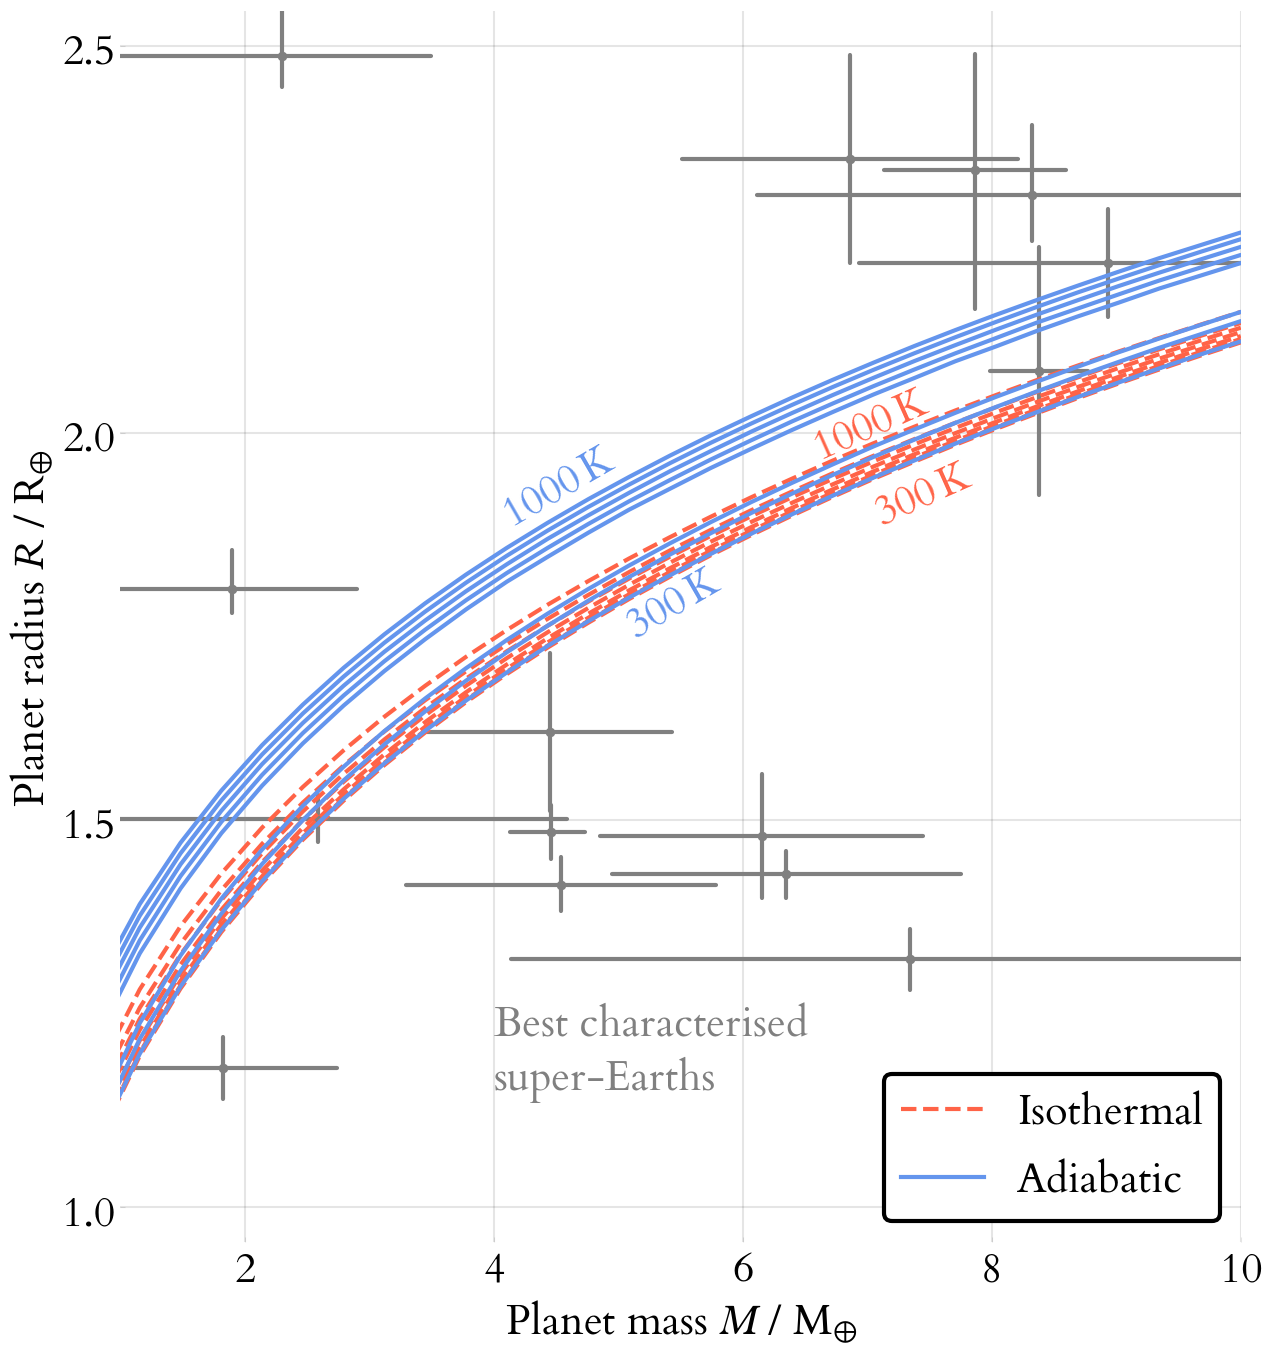

In [17]:
# this one's broken because of errorbar problems in Plots.jl :(
function plot_isotherms_vs_adiabats(source)
    d_iso = loaddata("generated/massradius/isotherms_vs_adiabats/$source/R_isotherm.csv")
    d_ad = loaddata("generated/massradius/isotherms_vs_adiabats/$source/R_adiabat.csv")
    Ms_iso = d_iso[:mass]
    Rs_iso = Array(d_iso[:, 2:end])
    Ms_ad = d_ad[:mass]
    Rs_ad = Array(d_ad[:, 2:end])
    
    smallplanets = @linq loaddata("raw/super-Earths.csv") |>
        transform(mPrecision = :MASS./:UMASS, rPrecision = :R./:UR) |>
        transform(precision = :mPrecision .* :rPrecision) |>
        where(:R .< 2.5) |>
        orderby(:precision) |>
        tail(15)    

    Mlim = [1, 10] * M_earth
    Rlim = [1, 2.5] * R_earth
    Mfmt = M -> round(Int, M/M_earth)
    Mticks = (0:2:10) * M_earth
    Rfmt = R -> R/R_earth
    Rticks = (1:0.5:2.5) * R_earth
    
    Mlabel = L"Planet mass $M$ / M$_⊕$"
    Rlabel = L"Planet radius $R$ / R$_⊕$"

    @with smallplanets begin 
        scatter(:MASS*M_earth, :R*R_earth, label="",
            xerr=(:MASSUPPER*M_earth,:MASSLOWER*M_earth), 
            yerr=(:RUPPER*R_earth, :RLOWER*R_earth),
            marker=stroke(0.5,"grey"),
            markersize=0)
        scatter!(:MASS*M_earth, :R*R_earth, label="", markercolor="grey", markerstrokewidth=0)
    end
    plot!(;xlim=Mlim, xformatter=Mfmt, xticks=Mticks, xlabel=Mlabel)
    plot!(;ylim=Rlim, yformatter=Rfmt, yticks=Rticks, ylabel=Rlabel)
    plot!(Ms_iso, Rs_iso, c=:tomato, s=:dash, lw=1, label="")
    plot!(Ms_ad, Rs_ad, c=:cornflowerblue, lw=1, label="")
    plot!([-99], [-99], c=:tomato, s=:dash, lw=1, label="Isothermal")
    plot!([-99], [-99], c=:cornflowerblue, lw=1, label="Adiabatic")
    xlims!(Mlim...)
    plot!(framestyle = :grid)
    
    annotate_color!(5M_earth, 1.78R_earth, L"$300\,$K", :cornflowerblue, rotation=30)
    annotate_color!(4M_earth, 1.93R_earth, L"$1000\,$K", :cornflowerblue, rotation=30)
    annotate_color!(7M_earth, 1.92R_earth, L"$300\,$K", :tomato, rotation=24)
    annotate_color!(6.5M_earth, 2.01R_earth, L"$1000\,$K", :tomato, rotation=24)
    annotate_color!(4M_earth, 1.2R_earth, "Best characterised\nsuper-Earths", :grey)
end

autofig("isotherms-vs-adiabats", Normal, vscale=1.6) do
    plot_isotherms_vs_adiabats("ogre")
end;

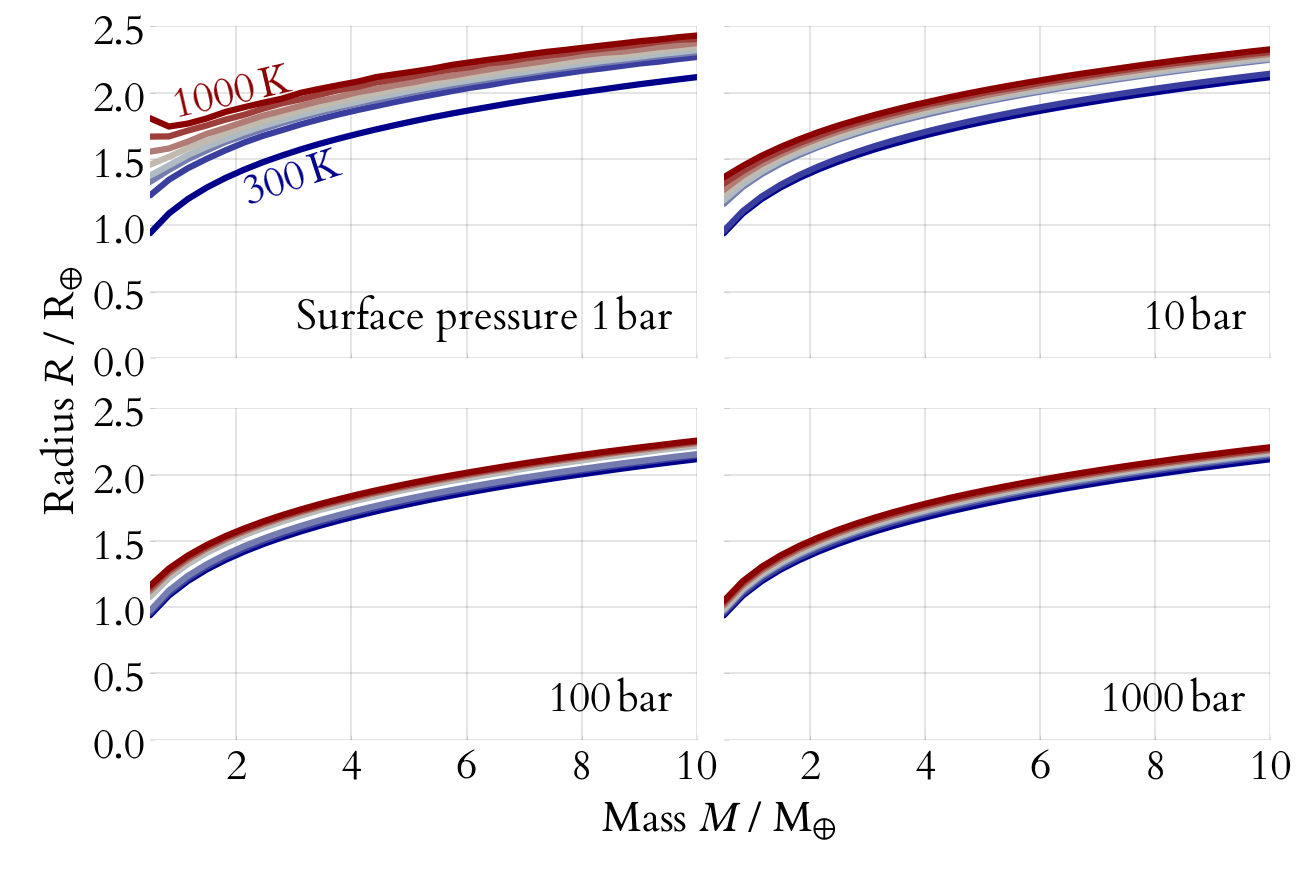

In [8]:
function surface_pressure_plot(source)
    Ts = 300:100:1000
    colors = seqcolors(:redsblues, length(Ts), 0, 1) |> reverse
    radii_cols = [Symbol("x$T") for T in Ts]
    logPs = [5,6,7,8]
    
    p = plot(layout=4, link=:both, legend=false, framestyle = :grid,
        xlim=(0.5,10), ylim=(0,2.5), palette=colors)
    for (i, logP) in enumerate(logPs)
        d = loaddata("generated/massradius/surfacepressures/$source/1e$logP.csv")
        xs = vec(d[:mass])
        ys = Array(d[radii_cols])
        
        plot!(p[i], xs/M_earth, ys/R_earth)
    end
    
    # remove tick labels in unnecessary places
    for i=1:2
        remove_ticklabels!(p[i], x=true, y=false)
        remove_ticklabels!(p[2i], x=false, y=true)
    end
    
    annotate_color!(p[1], 0.8, 2.0, L"1000$\,$K", colors[end], rotation=13)
    annotate_color!(p[1], 2, 1.35, L"300$\,$K", colors[1], rotation=18)
    
    annotate_color!(p[1], 9.6, 0.3, L"Surface pressure 1$\,$bar", :black, position=:right)
    annotate_color!(p[2], 9.6, 0.3, L"10$\,$bar", :black, position=:right)
    annotate_color!(p[3], 9.6, 0.3, L"100$\,$bar", :black, position=:right)
    annotate_color!(p[4], 9.6, 0.3, L"1000$\,$bar", :black, position=:right)
    
    # oh god this is hacky
    xlabel = L"Mass $M$ / M$_⊕$"
    xlabel_spaced = repeat(" ", 53) * xlabel
    xlabel!(p[3], xlabel_spaced)
    ylabel = L"Radius $R$ / R$_⊕$"
    ylabel_spaced = repeat(" ", 33) * ylabel
    ylabel!(p[3], ylabel_spaced)
end

autofig("surface-pressure-panels", Normal) do
    surface_pressure_plot("onion")
end;

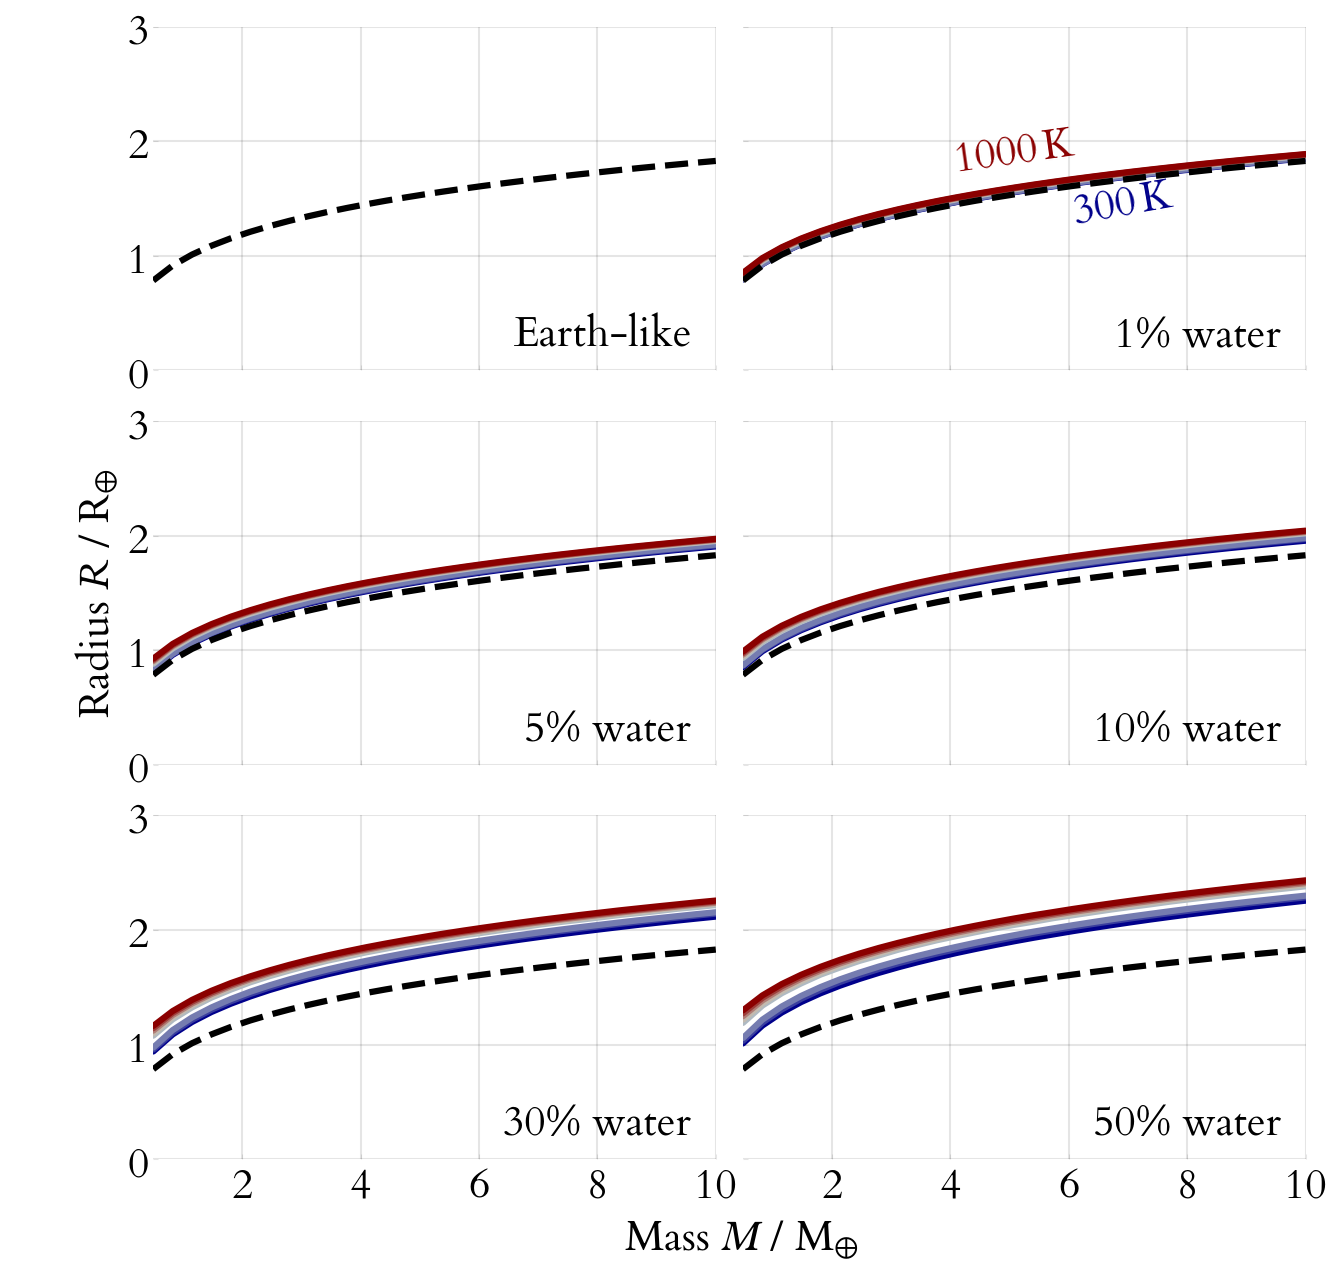

In [9]:
function water_fraction_plot(source)
    Ts = 300:100:1000
    colors = seqcolors(:redsblues, length(Ts), 0, 1) |> reverse
    radii_cols = [Symbol("x$T") for T in Ts]
    
    noticks = Float64[]
    
    dry = loaddata("generated/massradius/h2ofractions/$source/0pc.csv")
    dryx = vec(dry[:mass])
    dryy = vec(dry[:x300])
    
    p = plot(layout=grid(3,2), link=:both, legend=false, palette=colors, 
        framestyle = :grid,
        xlim=(0.5,10), ylim=(0,3), yticks=0:3)
    
    for (i, h2opc) in enumerate([0, 1, 5, 10, 30, 50])
        d = loaddata("generated/massradius/h2ofractions/$source/$(h2opc)pc.csv")
        x = vec(d[:mass])
        ys = Array(d[:, radii_cols])

        (h2opc != 0) && plot!(p[i], x/M_earth, ys/R_earth, palette=colors)
        plot!(p[i], dryx/M_earth, dryy/R_earth, linecolor=:black, linestyle=:dash)
    end
    
    # remove tick labels in unnecessary places
    for i=2:2:6; remove_ticklabels!(p[i], x=false, y=true); end
    for i=1:4; remove_ticklabels!(p[i], x=true, y=false); end
    
    annotate_color!(p[2], 4, 1.9, L"1000$\,$K", colors[end], rotation=8)
    annotate_color!(p[2], 6, 1.45, L"300$\,$K", colors[1], rotation=10)
    
    annotate_color!(p[1], 9.6, 0.3, "Earth-like", :black, position=:right)
    annotate_color!(p[2], 9.6, 0.3, "1% water", :black, position=:right)
    annotate_color!(p[3], 9.6, 0.3, "5% water", :black, position=:right)
    annotate_color!(p[4], 9.6, 0.3, "10% water", :black, position=:right)
    annotate_color!(p[5], 9.6, 0.3, "30% water", :black, position=:right)
    annotate_color!(p[6], 9.6, 0.3, "50% water", :black, position=:right)
    
    # oh god this is hacky
    xlabel = L"Mass $M$ / M$_⊕$"
    xlabel_spaced = repeat(" ", 55) * xlabel
    xlabel!(p[5], xlabel_spaced)
    ylabel = L"Radius $R$ / R$_⊕$"
    ylabel!(p[3], ylabel)
end

autofig("water-fraction-panels", Normal, vscale=1.5) do
    water_fraction_plot("onion")
end;